In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
import tensorflow.keras as k
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tkn import TKN

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

INFO:tensorflow:Using local port 18875
INFO:tensorflow:Using local port 18504
INFO:tensorflow:Using local port 22534
INFO:tensorflow:Using local port 24784
INFO:tensorflow:Using local port 22224
INFO:tensorflow:Using local port 15696
INFO:tensorflow:Using local port 24936
INFO:tensorflow:Using local port 16933
INFO:tensorflow:Using local port 17782
INFO:tensorflow:Using local port 20611
Tensorflow version: 2.4.0-dev20201012
Num GPUs Available:  1


In [2]:
# HYPERPARAMETERS
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [3]:
data_path = '/home/jbao/data/cd560d6ec65c4e79.csv'

df = pd.read_csv(data_path, delimiter=',', usecols=['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK', 'ASKSIZ', 'SYM_ROOT'], nrows=50000)

# Replace 0 to avoid dividing by 0 later on
# TODO: SHOULD USE FFILL, but doesn't work if first entry is 0
# or IDEALLY, USE SOME METHOD TO INDICATE VOLUME IS 0
df['BID'].replace(to_replace=0, method='bfill', inplace=True)
df['ASK'].replace(to_replace=0, method='bfill', inplace=True)
df['BIDSIZ'].replace(to_replace=0, method='bfill', inplace=True)
df['ASKSIZ'].replace(to_replace=0, method='bfill', inplace=True)
df.sort_values(by=['DATE', 'TIME_M'], inplace=True)
df.head()

,DATE,TIME_M,BID,BIDSIZ,ASK,ASKSIZ,SYM_ROOT
0,20200102,4:00:00.003659669,323.16,3,324.08,3,SPY
1,20200102,4:00:00.003686844,323.16,3,324.08,3,SPY
2,20200102,4:00:00.017900512,321.86,1,323.58,51,SPY
3,20200102,4:00:00.017906853,321.86,1,323.58,51,SPY
4,20200102,4:00:00.018297833,321.89,2,323.58,51,SPY


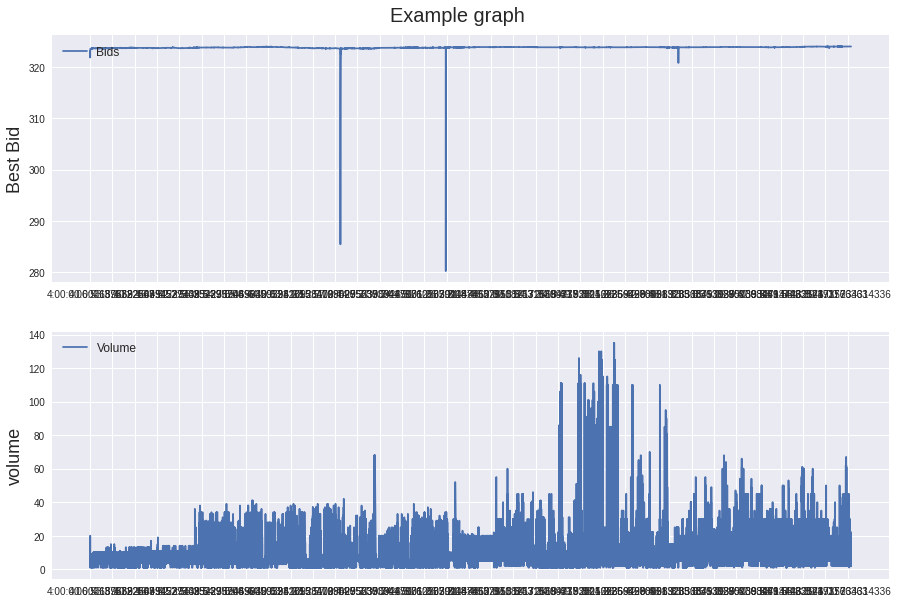

In [4]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Example graph", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['BID'], label='Bids')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['TIME_M'].loc[::1464])
ax1.set_ylabel('Best Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['BIDSIZ'], label='Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['TIME_M'].loc[::1464])
ax2.set_ylabel('volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [5]:
'''Calculate percentage change'''

df['BID'] = df['BID'].pct_change()
df['BIDSIZ'] = df['BIDSIZ'].pct_change()
df['ASK'] = df['ASK'].pct_change()
df['ASKSIZ'] = df['ASKSIZ'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values




'''Normalize price columns'''

min_return = min(df[['BID', 'ASK']].min(axis=0))
max_return = max(df[['BID', 'ASK']].max(axis=0))

print(min_return)
print(max_return)

# Min-max normalize price columns (0-1 range)
df['BID'] = (df['BID'] - min_return) / (max_return - min_return)
df['ASK'] = (df['ASK'] - min_return) / (max_return - min_return)





'''Normalize volume column'''

min_volume = min(df[['BIDSIZ', 'ASKSIZ']].min(axis=0))
max_volume = max(df[['BIDSIZ', 'ASKSIZ']].max(axis=0))

# Min-max normalize volume columns (0-1 range)
df['BIDSIZ'] = (df['BIDSIZ'] - min_volume) / (max_volume - min_volume)
df['ASKSIZ'] = (df['ASKSIZ'] - min_volume) / (max_volume - min_volume)






'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date, time, symbol column
df_train.drop(columns=['DATE'], inplace=True)
df_val.drop(columns=['DATE'], inplace=True)
df_test.drop(columns=['DATE'], inplace=True)

df_train.drop(columns=['TIME_M'], inplace=True)
df_val.drop(columns=['TIME_M'], inplace=True)
df_test.drop(columns=['TIME_M'], inplace=True)

df_train.drop(columns=['SYM_ROOT'], inplace=True)
df_val.drop(columns=['SYM_ROOT'], inplace=True)
df_test.drop(columns=['SYM_ROOT'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.tail()

-0.13464686081344002
0.17407155657171103
Training data shape: (40000, 4)
Validation data shape: (5000, 4)
Test data shape: (4999, 4)


,BID,BIDSIZ,ASK,ASKSIZ
39996,0.436148,0.002093,0.436148,0.002513
39997,0.435948,0.000699,0.436348,0.001001
39998,0.436248,0.001793,0.436148,0.002513
39999,0.436248,0.000497,0.436048,0.002513
40000,0.436048,0.017626,0.436148,0.002513


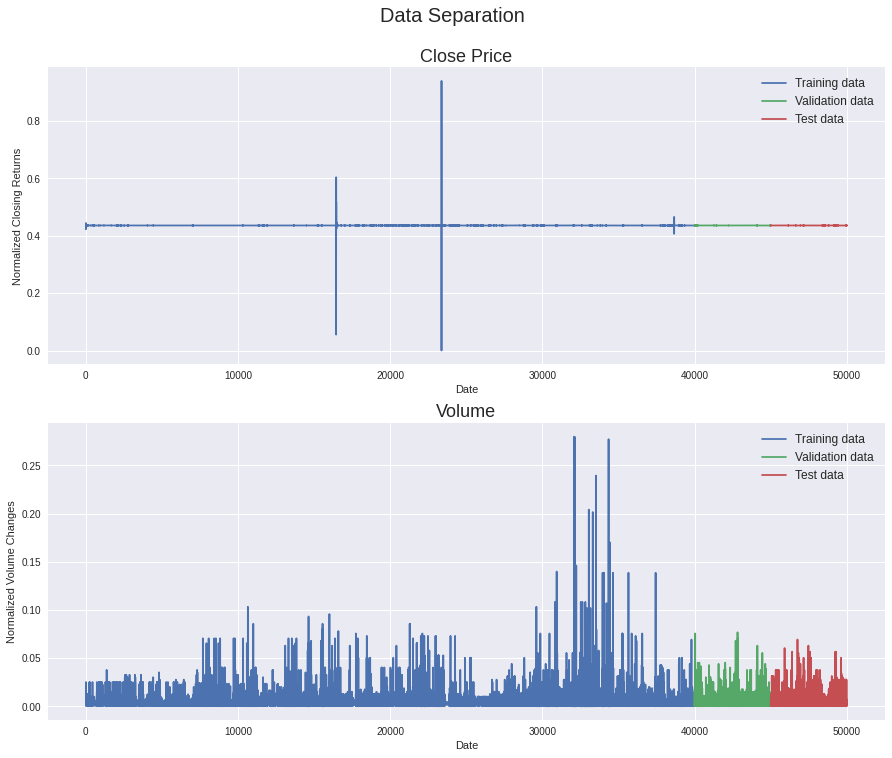

In [6]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['BID'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['BID'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['BID'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['BIDSIZ'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['BIDSIZ'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['BIDSIZ'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [7]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (39872, 128, 4) (39872,)
Validation set shape (4872, 128, 4) (4872,)
Testing set shape (4871, 128, 4) (4871,)


In [8]:
model = TKN(seq_len, d_k, d_v, n_heads, ff_dim)
model.compile(optimizer=k.optimizers.Adam(clipnorm=5.0), loss=k.losses.MeanSquaredError())

train_pred = model.predict(X_test)
print(train_pred)

[[ 3.9736431e-08  1.9868216e-08  0.0000000e+00 ...  1.9868216e-08
  -1.9868216e-08  0.0000000e+00]
 [ 0.0000000e+00 -1.9868216e-08  3.9736431e-08 ...  0.0000000e+00
   1.9868216e-08 -3.9736431e-08]
 [ 0.0000000e+00  1.9868216e-08 -5.9604645e-08 ...  0.0000000e+00
   0.0000000e+00  1.9868216e-08]
 ...
 [ 0.0000000e+00 -3.9736431e-08 -1.9868216e-08 ... -1.9868216e-08
   3.9736431e-08 -1.9868216e-08]
 [-3.9736431e-08 -1.9868216e-08 -3.9736431e-08 ...  1.9868216e-08
   0.0000000e+00  3.9736431e-08]
 [ 3.9736431e-08  1.9868216e-08 -1.9868216e-08 ...  0.0000000e+00
   0.0000000e+00  1.9868216e-08]]
